In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from src.behavior_tracking import extract_position_data

video_filename = '../Raw-Data/vx1_JZ1/raw/20161114/20161114_JZ1_02.1.h264'

position = extract_position_data(video_filename, cm_to_pixels=0.06545)

/Users/edeno/Documents/GitHub/Roumis_2018/src/behavior_tracking.py:268: RuntimeWarning: Mean of empty slice
  initial_x = np.nanmean(data[:, [0, 2]], axis=1)
/Users/edeno/Documents/GitHub/Roumis_2018/src/behavior_tracking.py:271: RuntimeWarning: Mean of empty slice
  initial_y = np.nanmean(data[:, [1, 3]], axis=1)


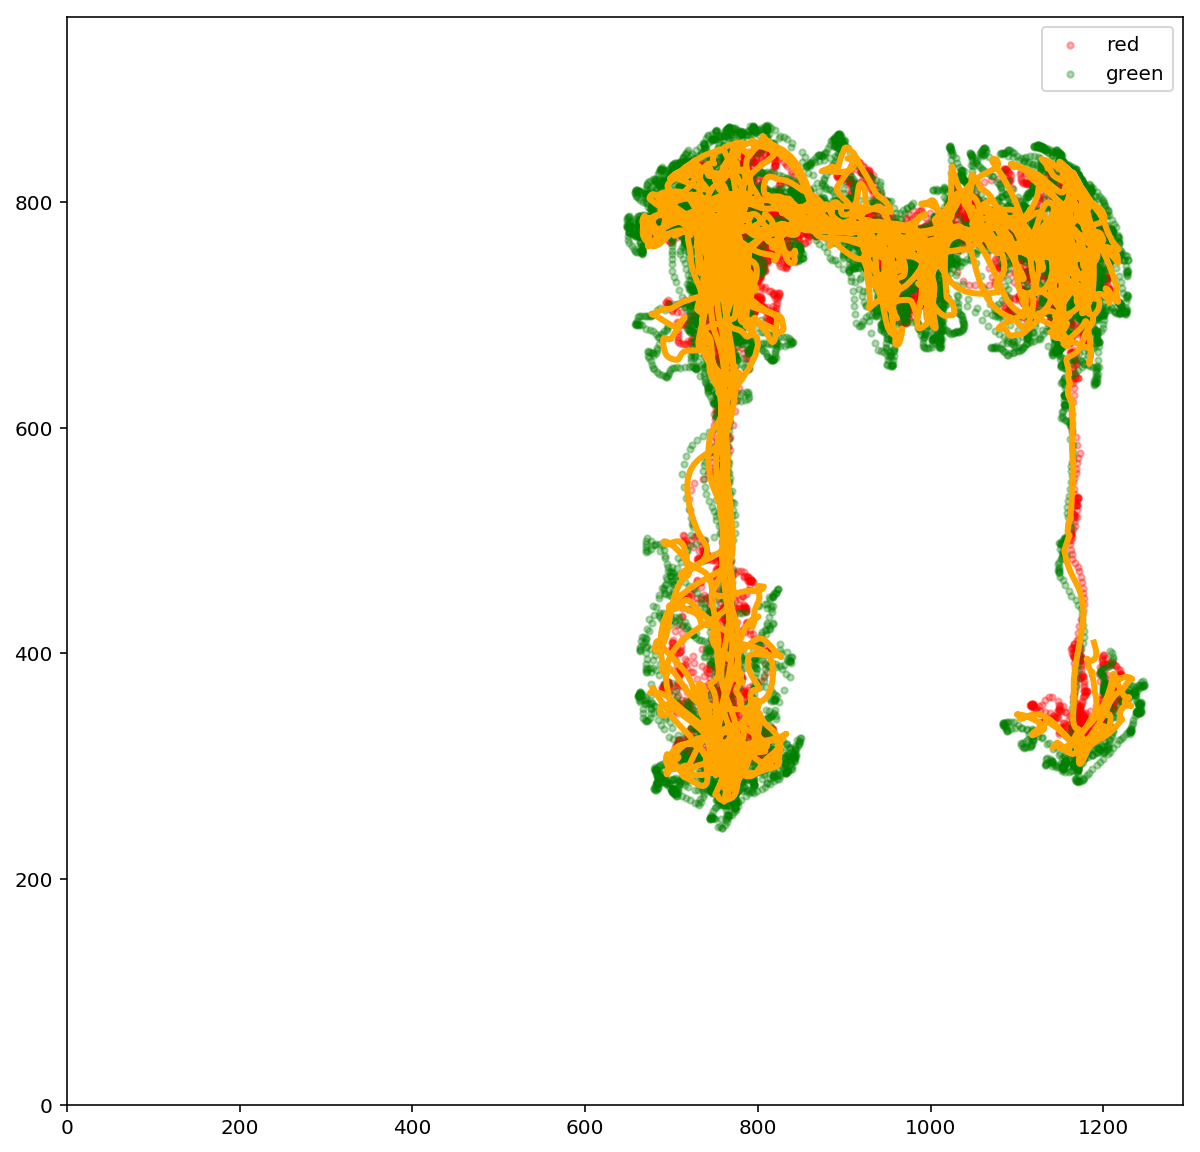

In [151]:
plt.figure(figsize=(10, 10))
for color, centroid in centroids.items():
    plt.scatter(centroid[:, 0], centroid[:, 1], color=color,
                label=color, s=10, zorder=-1, alpha=0.3);

        
plt.plot(posterior_mean[:, 0], posterior_mean[:, 3], color='orange', linewidth=3)
plt.xlim((0, frame_size[0]))
plt.ylim((0, frame_size[1]))
plt.legend();

In [113]:
from src.behavior_tracking import make_video

make_video(video_filename, centroids, posterior_mean,
           output_video_filename='output3.avi')

In [159]:
cm_to_pixels = 0.06545 
converted_centroids = {
        color: convert_video_coordinates(data, frame_size) * cm_to_pixels
        for color, data in centroids.items()}


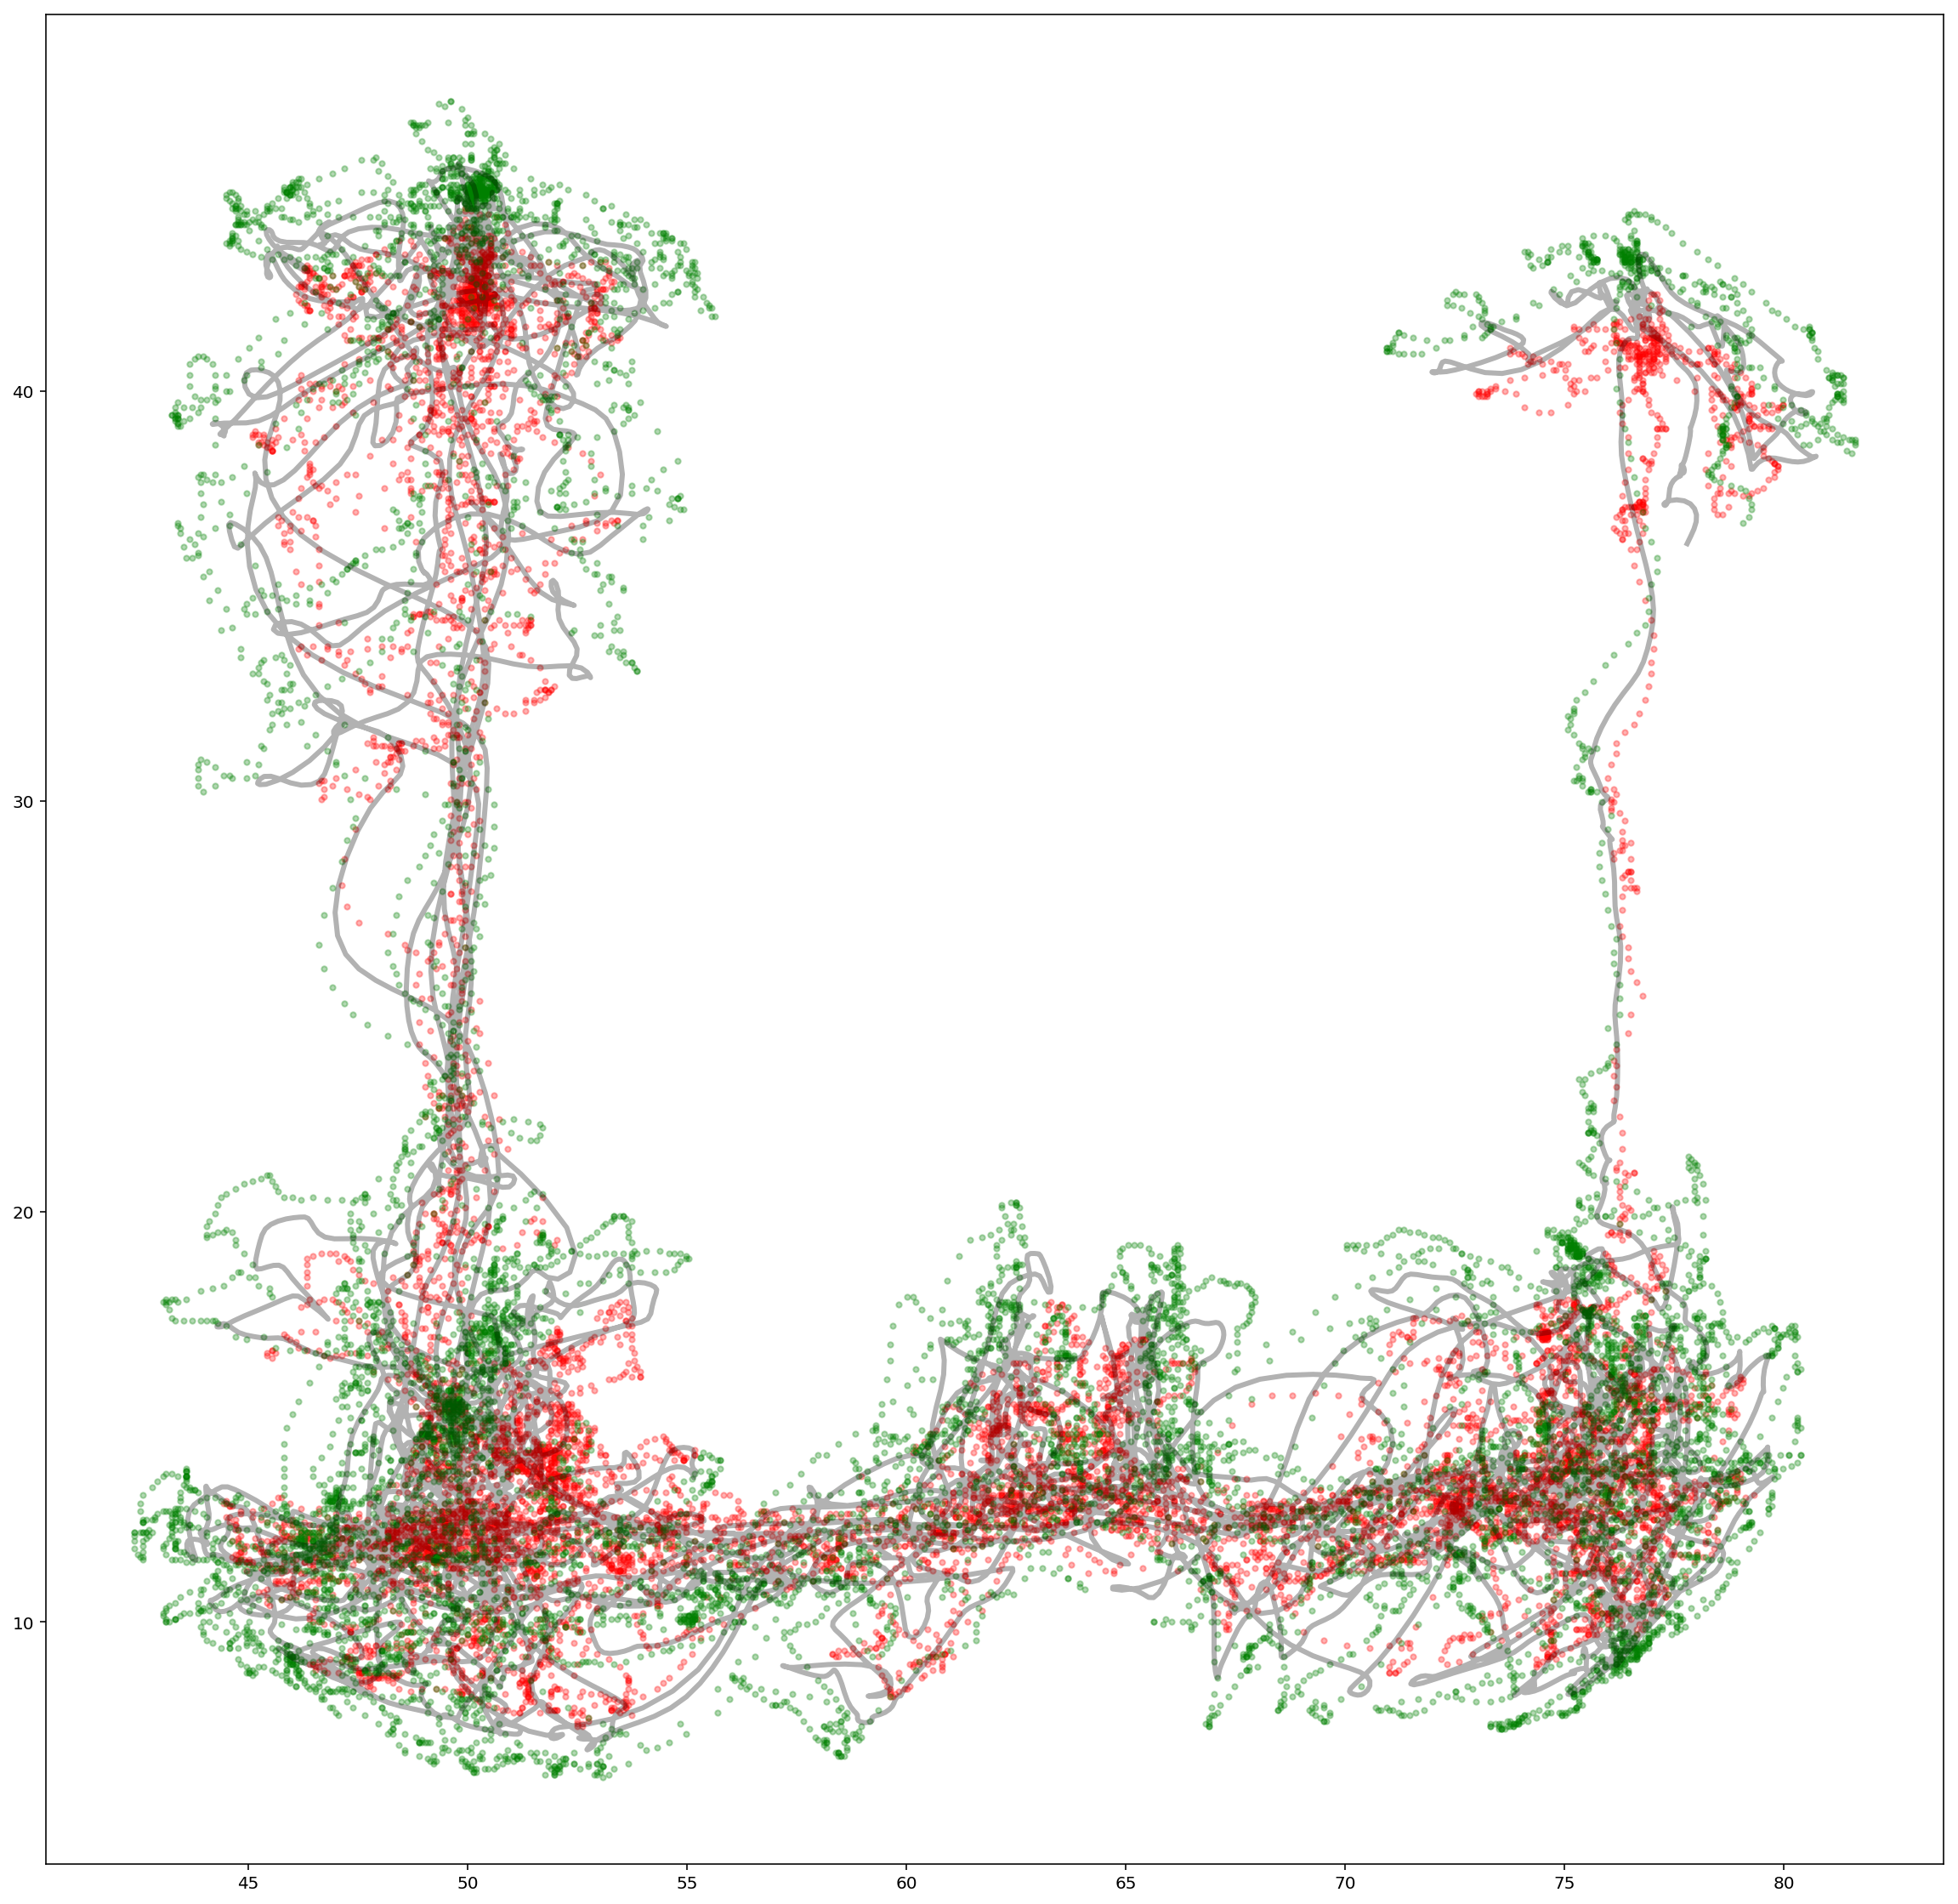

In [181]:
from src.behavior_tracking import filter_smooth_data
from src.behavior_tracking import make_head_position_model

head_position_model = make_head_position_model(converted_centroids, frame_rate,
                                               measurement_variance=1E-4, process_variance=10)
posterior_mean, posterior_covariance = filter_smooth_data(
    head_position_model)


plt.figure(figsize=(20, 20))
for color, centroid in converted_centroids.items():
    plt.scatter(centroid[:, 0], centroid[:, 1], color=color,
                label=color, s=10, zorder=-1, alpha=0.3);

plt.plot(posterior_mean[:, 0], posterior_mean[:, 3],
         color='black', linewidth=3, alpha=0.3)


In [187]:
converted_back = {
        color: convert_video_coordinates(data / cm_to_pixels, frame_size)
        for color, data in converted_centroids.items()}

convert_video_coordinates(posterior_mean[:, [0, 3]] / cm_to_pixels, frame_size)

array([[ 720.08966293,  784.93584041],
       [ 722.70290144,  785.4746354 ],
       [ 725.13642073,  786.14809067],
       ...,
       [1190.98083494,  404.29176147],
       [1189.83189314,  407.02843269],
       [1188.5979867 ,  409.75782514]])

In [188]:
position = extract_position_data(video_filename, cm_to_pixels=0.06545)

In [199]:
from src.behavior_tracking import make_video

make_video(video_filename, position.centroids, position.head_position_mean,
           position.head_orientation_mean,
           output_video_filename='output4.avi', cm_to_pixels=0.06545)

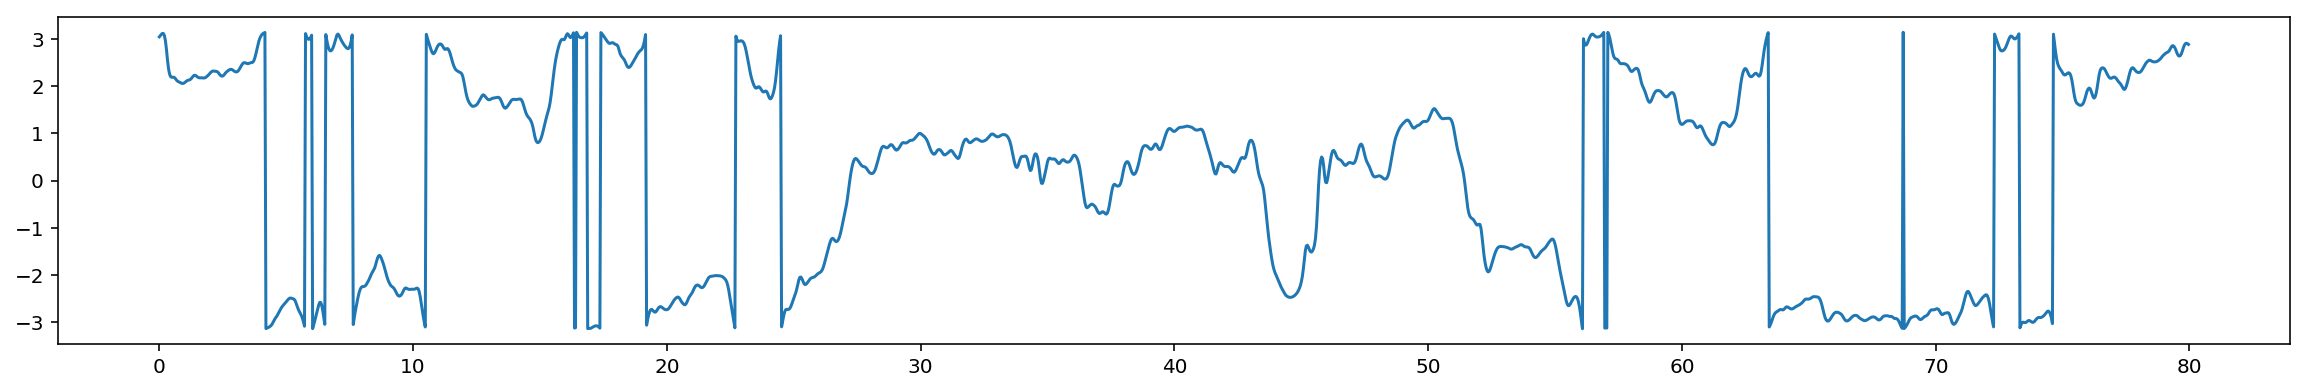

In [241]:
import pandas as pd

head_direction = np.arctan2(
    np.diff(position.head_orientation_mean[:, [3, 9]], axis=1),
    np.diff(position.head_orientation_mean[:, [0, 6]], axis=1))

plt.figure(figsize=(20, 3))
plt.plot(np.arange(2000) / frame_rate, head_direction[:2000])

In [252]:
head_direction = np.arctan2(
    np.diff(position.head_orientation_mean[:, [3, 9]], axis=1),
    np.diff(position.head_orientation_mean[:, [0, 6]], axis=1))

new_position_info = pd.DataFrame(position.head_position_mean, columns=STATE_NAMES)
new_position_info['head_direction'] = head_direction
new_position_info['speed'] = np.sqrt(new_position_info.x_velocity ** 2 + new_position_info.y_velocity ** 2)
new_position_info['acceleration'] = np.sqrt(new_position_info.x_acceleration ** 2 + new_position_info.y_acceleration ** 2)

In [339]:
from scipy.io import savemat, loadmat

animal = 'JZ1'
file_type = 'pos'
day = 2
n_epochs = 9
epoch = 5


filename = f'{animal}{file_type}{day:02d}.mat'

try:
    pos = loadmat(filename)
    pos = pos['pos']
except FileNotFoundError:
    pos = np.zeros((1, day), dtype=np.object)
    pos[0, day - 1] = np.zeros((1, n_epochs), dtype=np.object)

loren_frank_variable_names = {
    'time': 'time',
    'x_position': 'x',
    'y_position': 'y',
    'head_direction': 'dir',
    'speed': 'vel'
}


data = (new_position_info
        .reset_index()
        .rename(columns=loren_frank_variable_names)
        .loc[:, loren_frank_variable_names.values()])
fields = ' '.join(data.columns)

pos[0, day - 1][0, epoch - 1] = {
    'arg': [],
    'descript': [],
    'fields': fields,
    'data': data.values,
    'cmperpixel': [],
}

savemat(filename, {file_type: pos})


/Users/edeno/miniconda3/envs/Roumis_2018/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [359]:
def save_loren_frank_data(epoch_key, file_type, save_data, n_epochs=None):
    '''Saves data in the Loren Frank file format.
    
    Parameters
    ----------
    epoch_key : tuple
        (animal, day epoch)
    file_type : str
        The type of data being saved e.g. 'pos'.
    save_data : object
        Data to save.
    n_epochs : int, optional
        Total number of epochs per recording day.
    
    '''
    animal, day, epoch = epoch_key
    filename = f'{animal}{file_type}{day:02d}.mat'
    if n_epochs is None:
        n_epochs = epoch
    
    try:
        file_data = loadmat(filename)
        file_data = file_data[file_type]
    except FileNotFoundError:
        file_data = np.zeros((1, day), dtype=np.object)
        file_data[0, day - 1] = np.zeros((1, n_epochs), dtype=np.object)
    
    try:
        file_data[0, day - 1][0, epoch - 1] = save_data
    except IndexError:
        old_data = file_data[0, day - 1].copy()
        file_data[0, day - 1] = np.zeros((1, n_epochs), dtype=np.object)
        file_data[0, day - 1][0, :old_data.shape[1]] = old_data
        file_data[0, day - 1][0, epoch - 1] = save_data
        
    savemat(filename, {file_type: file_data})
    
    
def convert_to_loren_frank_data_format(new_position_info, cm_to_pixels=1.0):
    LOREN_FRANK_NAMES = {
        'time': 'time',
        'x_position': 'x',
        'y_position': 'y',
        'head_direction': 'dir',
        'speed': 'vel'
    }


    data = (new_position_info
            .reset_index()
            .rename(columns=LOREN_FRANK_NAMES)
            .loc[:, LOREN_FRANK_NAMES.values()])
    fields = ' '.join(data.columns)
    
    return {
        'arg': [],
        'descript': [],
        'fields': fields,
        'data': data.values,
        'cmperpixel': cm_to_pixels,
    }




epoch_key = ('JZ1', 2, 11)

save_data = convert_to_loren_frank_data_format(new_position_info, cm_to_pixels=0.06545)

save_loren_frank_data(epoch_key, 'pos', save_data)

/Users/edeno/miniconda3/envs/Roumis_2018/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [379]:
def video_filename_to_epoch_key(video_filename, date_to_day):
    date, animal, epoch = video_filename.split('/')[-1].split('.')[0].split('_')
    epoch = int(epoch)
    day = date_to_day[date]
    return animal, day, epoch


date_to_day = {
    '20161114': 1,
    '20161115': 2,
    '20161116': 3,
    '20161117': 4,
    '20161118': 5,
    '20161119': 6,
    '20161121': 7,
}

video_filename_to_epoch_key(video_filename, date_to_day)

('JZ1', 1, 2)

In [385]:
import json

In [389]:
data = {'date_to_day': date_to_day,
        'cm_to_pixels': 0.06545}

with open('position_config.json', 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4,
               ensure_ascii=False)

with open('position_config.json') as data_file:
    data_loaded = json.load(data_file)

In [445]:
video_filename = '../Raw-Data/vx1_JZ1/raw/20161114/20161114_JZ1_07.1.h264'
position = extract_position_data(video_filename, cm_to_pixels=0.06545)

/Users/edeno/Documents/GitHub/Roumis_2018/src/behavior_tracking.py:249: RuntimeWarning: Mean of empty slice
  initial_y = (data[0, 1] + data[0, 3]) / 2
/Users/edeno/Documents/GitHub/Roumis_2018/src/behavior_tracking.py:252: RuntimeWarning: Mean of empty slice
  prior_covariance = np.diag([1, 250, 6000, 1, 250, 6000])


In [446]:
from src.behavior_tracking import video_filename_to_epoch_key

epoch_key = video_filename_to_epoch_key(
    video_filename, date_to_day)


In [527]:
from src.behavior_tracking import detect_LEDs

detect_LEDs(video_filename)

KeyboardInterrupt: 

In [542]:
from src.behavior_tracking import make_video

animal, day, epoch = epoch_key
output_video_filename = f'{animal}_{day:02}_{epoch:02}_pos.avi'
make_video(video_filename, position.centroids,
           position.head_position_mean,
           position.head_orientation_mean,
           output_video_filename=output_video_filename,
           cm_to_pixels=0.06545)


In [699]:
from scipy.io import loadmat
import os

def adjust_time(position_filename):
    pass

FIVE_MINUTES = 300
TIME_IND = 0

position_filename = '../Raw-Data/JZ1/JZ1pos03.mat'
animal, day = (position_filename.split(os.sep)[-1]
               .strip('.mat').split('pos'))
day = int(day)
position_file = loadmat(position_filename)
position_data = position_file['pos'][0, day - 1]


for epoch_ind, epoch in enumerate(position_data.squeeze()):
    current_epoch_time = epoch['data'][0, 0][:, TIME_IND].copy()
    current_epoch_time -= current_epoch_time[0]
    previous_epoch_time = position_data[0, epoch_ind - 1]['data'][0, 0][:, TIME_IND]
    
    if epoch_ind != 0:
        new_epoch_time_start = previous_epoch_time[-1] + FIVE_MINUTES
        position_data[0, epoch_ind]['data'][0, 0][:, TIME_IND] = current_epoch_time + new_epoch_time_start



    
    



0.0197
1614.0754
3151.7825333333335
4710.479666666667
6217.948733333334
7751.282
9263.684833333333
10169.1368
12063.996133333334
0.0197
1614.016
3151.665
4710.273733333333
6217.6651999999995
7750.925566666666
9263.248666666666
10168.616666666667
12063.379466666667
0.0197
1614.016
3151.665
4710.273733333333
6217.6651999999995
7750.925566666666
9263.248666666666
10168.616666666667
12063.379466666667
